In [88]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

# from statsmodels.tsa.api import VAR, VECM
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen

file_path = Path("round-3-island-data-bottle")

In [42]:
if file_path.exists():
    # Read the CSV file
    df_day_0 = pd.read_csv(
        file_path / "prices_round_3_day_0.csv", delimiter=";"
    )  # day 0
    df_day_1 = pd.read_csv(
        file_path / "prices_round_3_day_1.csv", delimiter=";"
    )  # day 1
    df_day_2 = pd.read_csv(
        file_path / "prices_round_3_day_2.csv", delimiter=";"
    )  # day 2
    print("File loaded successfully.")
else:
    print("File not found. Please ensure the file exists at:", file_path)

df_day_0["timestamp"] = pd.to_numeric(df_day_0["timestamp"])
df_day_1["timestamp"] = pd.to_numeric(df_day_1["timestamp"])
df_day_2["timestamp"] = pd.to_numeric(df_day_2["timestamp"])

# df_day_1["timestamp"] += 999801
# df_day_2["timestamp"] += 999701

# df_day_min_1["DAY"] = "day_-1"
# df_day_0["DAY"] = "day_0"
# df_day_plus_1["DAY"] = "day_+1"

# day_to_num = {"day_-1": -1, "day_0": 0, "day_+1": 1}


# df = pd.concat([df_day_0, df_day_1, df_day_2], ignore_index=True)

File loaded successfully.


In [43]:
df_day_0.head(10)

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,0,CHOCOLATE,7999,111,NaN,NaN,NaN,NaN,8001,111,NaN,NaN,NaN,NaN,8000.0,0.0
1,0,0,STRAWBERRIES,3999,210,NaN,NaN,NaN,NaN,4001,210,NaN,NaN,NaN,NaN,4000.0,0.0
2,0,0,ROSES,14999,72,NaN,NaN,NaN,NaN,15001,72,NaN,NaN,NaN,NaN,15000.0,0.0
3,0,0,GIFT_BASKET,71348,19,71347.0,24.0,NaN,NaN,71362,19,71363.0,24.0,NaN,NaN,71355.0,0.0
4,0,100,GIFT_BASKET,71344,1,71343.0,12.0,71342.0,20.0,71355,1,71356.0,12.0,71357.0,20.0,71349.5,0.0
5,0,100,CHOCOLATE,8001,52,8000.0,95.0,NaN,NaN,8002,147,NaN,NaN,NaN,NaN,8001.5,0.0
6,0,100,ROSES,14999,66,NaN,NaN,NaN,NaN,15001,66,NaN,NaN,NaN,NaN,15000.0,0.0
7,0,100,STRAWBERRIES,3999,265,NaN,NaN,NaN,NaN,4000,265,NaN,NaN,NaN,NaN,3999.5,0.0
8,0,200,ROSES,15000,61,NaN,NaN,NaN,NaN,15001,21,15002.0,40.0,NaN,NaN,15000.5,0.0
9,0,200,GIFT_BASKET,71344,4,71339.0,1.0,71338.0,14.0,71350,1,71351.0,14.0,71352.0,21.0,71347.0,0.0


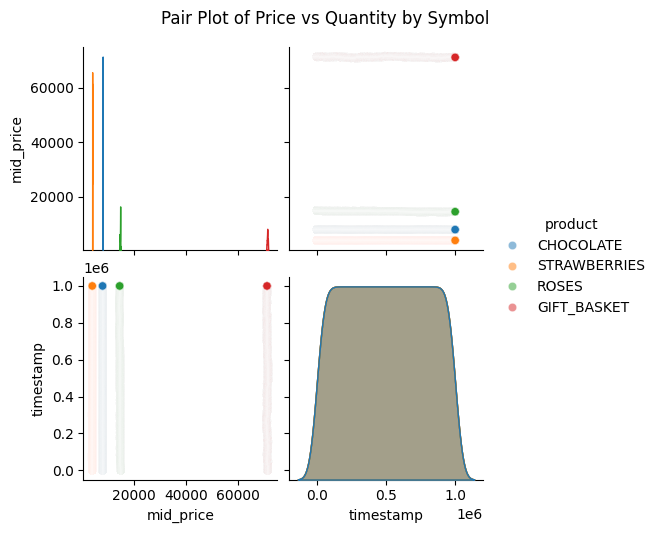

In [44]:
# Create a pair plot
pair_plot = sns.pairplot(
    df_day_0, vars=["mid_price", "timestamp"], hue="product", plot_kws={"alpha": 0.5}
)
pair_plot.fig.suptitle("Pair Plot of Price vs Quantity by Symbol", y=1.05)
plt.show()

## Modelling


In [45]:
# Note I am reading in day 1
df_day_0 = pd.read_csv(file_path / "prices_round_3_day_1.csv", delimiter=";")  # day 0
df_day_0.head(10)

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,1,0,GIFT_BASKET,71108,12,71107.0,27.0,NaN,NaN,71121,12,71122.0,27.0,NaN,NaN,71114.5,0.0
1,1,0,CHOCOLATE,7987,104,NaN,NaN,NaN,NaN,7989,104,NaN,NaN,NaN,NaN,7988.0,0.0
2,1,0,ROSES,14545,27,14544.0,34.0,NaN,NaN,14546,61,NaN,NaN,NaN,NaN,14545.5,0.0
3,1,0,STRAWBERRIES,4030,237,NaN,NaN,NaN,NaN,4031,237,NaN,NaN,NaN,NaN,4030.5,0.0
4,1,100,STRAWBERRIES,4030,52,4029.0,137.0,NaN,NaN,4031,189,NaN,NaN,NaN,NaN,4030.5,0.0
5,1,100,ROSES,14543,20,14542.0,36.0,NaN,NaN,14544,56,NaN,NaN,NaN,NaN,14543.5,0.0
6,1,100,GIFT_BASKET,71109,1,71107.0,12.0,71106.0,20.0,71119,1,71121.0,12.0,71122.0,20.0,71114.0,0.0
7,1,100,CHOCOLATE,7987,100,NaN,NaN,NaN,NaN,7989,100,NaN,NaN,NaN,NaN,7988.0,0.0
8,1,200,ROSES,14543,26,14542.0,36.0,NaN,NaN,14544,62,NaN,NaN,NaN,NaN,14543.5,0.0
9,1,200,STRAWBERRIES,4029,198,NaN,NaN,NaN,NaN,4031,209,NaN,NaN,NaN,NaN,4030.0,0.0


In [46]:
df_day_0 = pd.pivot_table(
    df_day_0, index="timestamp", columns="product", values="mid_price"
)
df_day_0 = df_day_0.apply(pd.to_numeric)
# df_day_0.rename_axis(None, axis=1).reset_index(drop=True)

df_day_0

product,CHOCOLATE,GIFT_BASKET,ROSES,STRAWBERRIES
timestamp,,,,
0,7988.0,71114.5,14545.5,4030.5
100,7988.0,71114.0,14543.5,4030.5
200,7987.5,71115.5,14543.5,4030.0
300,7988.5,71123.5,14541.5,4030.0
400,7989.5,71132.5,14547.5,4030.0
...,...,...,...,...
999500,7883.0,70589.5,14421.0,4036.5
999600,7885.5,70599.5,14418.0,4036.5
999700,7885.5,70585.5,14421.5,4035.5


In [47]:
assets = ["CHOCOLATE", "GIFT_BASKET", "ROSES", "STRAWBERRIES"]

for asset in assets:
    mod = AutoReg(df_day_0[asset].tolist(), 5, trend="n")
    res = mod.fit()
    print(f"Asset: {asset}")
    print(res.summary())
    print("\n")

Asset: CHOCOLATE
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                10000
Model:                     AutoReg(5)   Log Likelihood              -14303.506
Method:               Conditional MLE   S.D. of innovations              1.012
Date:                Fri, 19 Apr 2024   AIC                          28619.012
Time:                        12:29:59   BIC                          28662.271
Sample:                             5   HQIC                         28633.656
                                10000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.9779      0.010     97.781      0.000       0.958       0.997
y.L2           0.0289      0.014      2.070      0.038       0.002       0.056
y.L3           0.0021      0.014   

In [48]:
mod = VAR(df_day_0)
res = mod.fit(2)
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 19, Apr, 2024
Time:                     12:29:59
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    4.05363
Nobs:                     9998.00    HQIC:                   4.03646
Log likelihood:          -76844.5    FPE:                    56.1299
AIC:                      4.02767    Det(Omega_mle):         55.9283
--------------------------------------------------------------------
Results for equation CHOCOLATE
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  13.916942         5.517663            2.522           0.012
L1.CHOCOLATE            0.961326         0.011936           80.539           0.000
L1.GIFT_BASKET          0.003972         0.00164

/Users/tdafonseca/Library/Caches/pypoetry/virtualenvs/prosperity-year2-b-fUdz0r-py3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [49]:
df_day_0

product,CHOCOLATE,GIFT_BASKET,ROSES,STRAWBERRIES
timestamp,,,,
0,7988.0,71114.5,14545.5,4030.5
100,7988.0,71114.0,14543.5,4030.5
200,7987.5,71115.5,14543.5,4030.0
300,7988.5,71123.5,14541.5,4030.0
400,7989.5,71132.5,14547.5,4030.0
...,...,...,...,...
999500,7883.0,70589.5,14421.0,4036.5
999600,7885.5,70599.5,14418.0,4036.5
999700,7885.5,70585.5,14421.5,4035.5


# Model enhancement


1. Data Preprocessing
   Stationarity: Ensure that all series in your VAR model are stationary. This means that the mean, variance, and autocorrelation structure of the series do not change over time. Non-stationary data can lead to misleading results. Use difference transformations or seasonal adjustments if necessary.
   Outliers: Check for and handle outliers, as they can significantly distort the results of a VAR model.
   Normalization: Consider scaling your data (e.g., using Min-Max scaling or Z-score normalization). This is particularly useful if the variables are measured in different scales.
2. Model Specification
   Lag Length: The choice of lag length can significantly affect your model’s performance. You can use criteria like AIC (Akaike Information Criterion), BIC (Bayesian Information Criterion), or HQIC (Hannan-Quinn Information Criterion) to select an optimal lag length. It seems you have used 2 lags based on your description. Re-evaluate whether this is optimal using statistical tests or validation techniques.
   Error Correction: If your data series are cointegrated, consider using a Vector Error Correction Model (VECM) instead of a standard VAR. This model takes into account long-term equilibrium relationships between series, which can improve forecast accuracy.
3. Model Diagnostics
   Check for Serial Correlation: Use tests like the Durbin-Watson statistic to check for autocorrelation in the residuals of your VAR model. Autocorrelated residuals indicate that some information from the past is not captured by the model.
   Check for Stability: The roots of the characteristic equation of the VAR model should lie inside the unit circle for the model to be stable.
4. Forecasting
   Direct Forecasting: Use the forecast() method from your VAR model to predict future values. This method uses the coefficients estimated from historical data.
   Scenario-based Forecasting: Consider different scenarios for your exogenous variables to see how changes in one variable might affect others.
5. Validation
   Split the Data: Use train-test splits to validate your model's performance. This involves fitting the model on a training dataset and then testing it on unseen data.
   Cross-Validation: Implement time series cross-validation to assess the model's predictive power reliably.
6. Refinement and Reevaluation
   Regularly reevaluate and update the model as new data becomes available or as the economic environment changes.
   Continuously monitor the model's performance over time against actual outcomes and adjust as needed.


In [50]:
# Step 3: Ensure Stationarity
def test_stationarity(df):
    results = {}
    for column in df.columns:
        result = adfuller(df[column])
        results[column] = {
            "ADF Statistic": result[0],
            "p-value": result[1],
            "Critical Values": result[4],
        }
    return results


stationarity_results = test_stationarity(df_day_0)
print(stationarity_results)

{'CHOCOLATE': {'ADF Statistic': -1.4378159323441364, 'p-value': 0.5640185016051525, 'Critical Values': {'1%': -3.431004228818807, '5%': -2.8618291302145686, '10%': -2.566923898875394}}, 'GIFT_BASKET': {'ADF Statistic': -2.073435530936521, 'p-value': 0.25532956970033305, 'Critical Values': {'1%': -3.431004228818807, '5%': -2.8618291302145686, '10%': -2.566923898875394}}, 'ROSES': {'ADF Statistic': -2.2528027850345844, 'p-value': 0.18764187115562286, 'Critical Values': {'1%': -3.431004228818807, '5%': -2.8618291302145686, '10%': -2.566923898875394}}, 'STRAWBERRIES': {'ADF Statistic': -1.4109687741822972, 'p-value': 0.5770064000904294, 'Critical Values': {'1%': -3.4310043597505673, '5%': -2.8618291880722437, '10%': -2.5669239296731097}}}


In [51]:
# p-value > 0.05
df_day_0_diff = df_day_0.diff().dropna()

In [52]:
# Step 4: Handle Outliers
def remove_outliers(df):
    for column in df.columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    return df


df_day_0_clean = remove_outliers(df_day_0_diff)

In [53]:
# Step 5: Normalize Data Z-score
scaler = StandardScaler()

# Fit and transform the data
df_day_0_scaled = pd.DataFrame(scaler.fit_transform(df_day_0), columns=df_day_0.columns)

# Check the mean and standard deviation of the scaled data
print("mean")
print(df_day_0_scaled.mean())
print("\nStd dev:")
print(df_day_0_scaled.std())

mean
product
CHOCOLATE      -2.228262e-15
GIFT_BASKET    -2.546585e-14
ROSES           5.456968e-15
STRAWBERRIES    1.179501e-14
dtype: float64

Std dev:
product
CHOCOLATE       1.00005
GIFT_BASKET     1.00005
ROSES           1.00005
STRAWBERRIES    1.00005
dtype: float64


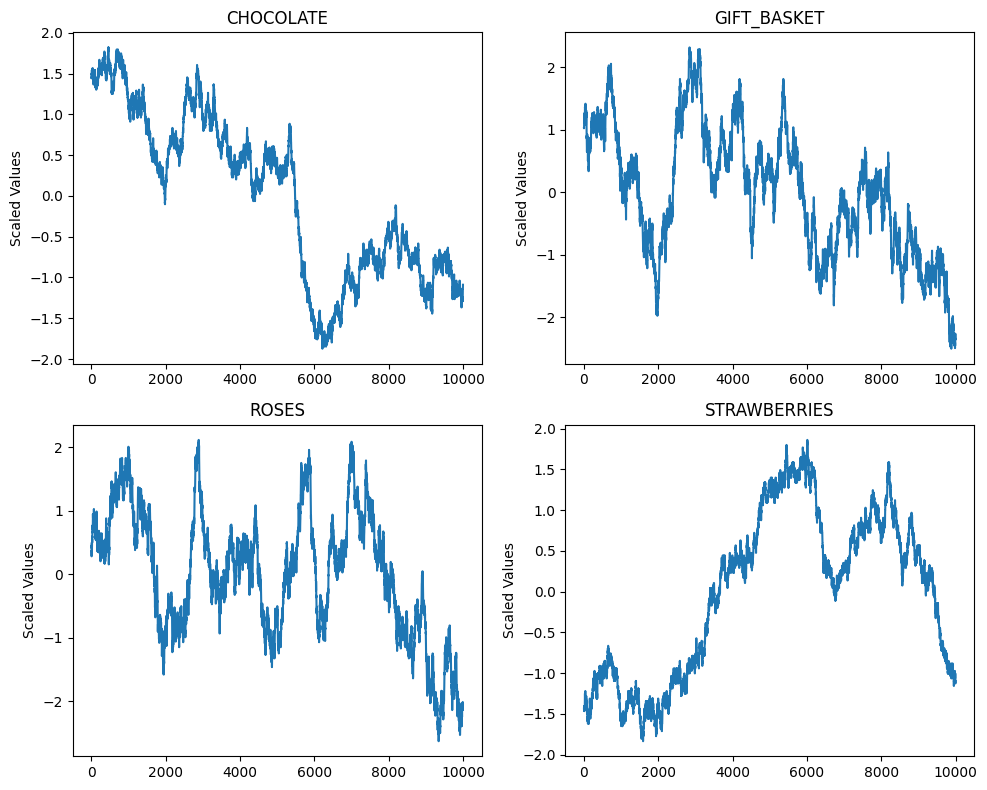

In [54]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
for i, col in enumerate(df_day_0_scaled.columns):
    df_day_0_scaled[col].plot(ax=axes[i // 2, i % 2], title=col).set_ylabel(
        "Scaled Values"
    )
plt.tight_layout()
plt.show()

Model Specification
Lag Length: The choice of lag length can significantly affect your model’s performance. You can use criteria like AIC (Akaike Information Criterion), BIC (Bayesian Information Criterion), or HQIC (Hannan-Quinn Information Criterion) to select an optimal lag length. It seems you have used 2 lags based on your description. Re-evaluate whether this is optimal using statistical tests or validation techniques.
Error Correction: If your data series are cointegrated, consider using a Vector Error Correction Model (VECM) instead of a standard VAR. This model takes into account long-term equilibrium relationships between series, which can improve forecast accuracy


In [55]:
model = VAR(df_day_0_scaled)

# Select the optimal lag length based on information criteria
lag_results = model.select_order(
    25
)  # Checking up to 15 lags, adjust based on your dataset size
print(lag_results.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -2.372      -2.369     0.09329      -2.371
1       -26.85      -26.83   2.192e-12      -26.84
2      -26.87*     -26.84*  2.147e-12*     -26.86*
3       -26.87      -26.83   2.150e-12      -26.85
4       -26.86      -26.81   2.155e-12      -26.85
5       -26.86      -26.80   2.159e-12      -26.84
6       -26.86      -26.79   2.164e-12      -26.83
7       -26.86      -26.77   2.165e-12      -26.83
8       -26.86      -26.76   2.170e-12      -26.82
9       -26.85      -26.75   2.173e-12      -26.82
10      -26.85      -26.73   2.177e-12      -26.81
11      -26.85      -26.72   2.182e-12      -26.81
12      -26.85      -26.71   2.183e-12      -26.80
13      -26.85      -26.70   2.187e-12      -26.80
14      -26.85      -26.68   2.191e-12      -26.79
15      -26.84      -26.67   2.195e-12      -26.78
16      -26.84      -26.65   2.

Step 3: Check for Cointegration
Before deciding whether to use VAR or VECM, check if the series are cointegrated.


In [56]:
# Applying the Johansen cointegration test
def check_cointegration(df, det_order=-1, k_ar_diff=1):
    """
    det_order : int {-1,0,1} -> -1 = no deterministic trend, 0 = constant term, 1 = linear trend
    k_ar_diff : int -> number of lags to be used in the Johansen cointegration test
    """
    result = coint_johansen(df, det_order, k_ar_diff)
    trace_stat = result.lr1  # Trace statistic
    cvt = result.cvt  # Critical values (90%, 95%, 99% confidence)
    print("Trace Statistic:", trace_stat)
    print("Critical Values (90%, 95%, 99%):", cvt)
    return result


# Conduct cointegration test
coint_results = check_cointegration(df_day_0_scaled, det_order=-1, k_ar_diff=2)

Trace Statistic: [43.72424232 22.02116565 11.69735155  2.61209098]
Critical Values (90%, 95%, 99%): [[37.0339 40.1749 46.5716]
 [21.7781 24.2761 29.5147]
 [10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]]


Step 4: Choosing Between VAR and VECM  
Based on the cointegration test results, decide whether to use VAR or VECM.


In [57]:
# If cointegration is detected, use VECM, otherwise stick to VAR
# if any(coint_results.lr1 > coint_results.cvt[:, 1]):  # Using 95% confidence level
#     print("Cointegration detected. Using VECM.")
#     vecm_model = VECM(
#         df_day_0_scaled, k_ar_diff=lag_results.selected_orders["aic"] - 1, coint_rank=1
#     )
#     vecm_result = vecm_model.fit()
#     print(vecm_result.summary())
# else:
#     print("No cointegration detected. Using VAR.")
#     var_model = VAR(df_day_0_scaled)
#     var_result = var_model.fit(maxlags=lag_results.selected_orders["aic"])
#     print(var_result.summary())

if any(coint_results.lr1 > coint_results.cvt[:, 1]):  # Using 95% confidence level
    print("Cointegration detected. Using VECM.")
    # Using 1 lag less than the optimal VAR order for VECM
    vecm_model = VECM(
        df_day_0_scaled, k_ar_diff=1, coint_rank=1
    )  # Adjust coint_rank based on the number of cointegrating relationships found, if needed
    vecm_result = vecm_model.fit()
    print(vecm_result.summary())
else:
    print("No cointegration detected. Using VAR.")
    # Using the optimal VAR order directly
    var_model = VAR(df_day_0_scaled)
    var_result = var_model.fit(maxlags=2)  # Adjusting to use lag length 2
    print(var_result.summary())

Cointegration detected. Using VECM.
Det. terms outside the coint. relation & lagged endog. parameters for equation CHOCOLATE
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
L1.CHOCOLATE       -0.0379      0.012     -3.178      0.001      -0.061      -0.015
L1.GIFT_BASKET      0.0158      0.007      2.426      0.015       0.003       0.029
L1.ROSES           -0.0022      0.005     -0.414      0.679      -0.012       0.008
L1.STRAWBERRIES    -0.0130      0.010     -1.321      0.186      -0.032       0.006
Det. terms outside the coint. relation & lagged endog. parameters for equation GIFT_BASKET
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
L1.CHOCOLATE        0.0399      0.024      1.668      0.095      -0.007       0.087
L1.GIFT_BASKET     -0.0387  

In [90]:
from statsmodels.tsa.vector_ar.vecm import VECM

vecm_model = VECM(df_day_0_scaled, k_ar_diff=2, coint_rank=1, deterministic="ci")
vecm_result = vecm_model.fit()
print(vecm_result.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation CHOCOLATE
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
L1.CHOCOLATE       -0.0385      0.012     -3.221      0.001      -0.062      -0.015
L1.GIFT_BASKET      0.0164      0.007      2.509      0.012       0.004       0.029
L1.ROSES           -0.0025      0.005     -0.478      0.633      -0.013       0.008
L1.STRAWBERRIES    -0.0127      0.010     -1.282      0.200      -0.032       0.007
L2.CHOCOLATE       -0.0021      0.012     -0.172      0.864      -0.025       0.021
L2.GIFT_BASKET      0.0085      0.007      1.307      0.191      -0.004       0.021
L2.ROSES           -0.0106      0.005     -2.027      0.043      -0.021      -0.000
L2.STRAWBERRIES     0.0063      0.010      0.634      0.526      -0.013       0.026
Det. terms outside the coint. relation & lagged endog. parameters for e

In [91]:
# Prediction Function: Create a function that will use the VECM model's fitted coefficients to predict future prices. Make sure to handle the lags appropriately.


def predict_gift_basket(df, vecm_result):
    # Calculate the estimated prices using the coefficients from VECM
    df["gift_basket_estimated"] = (
        vecm_result.const[0]
        + vecm_result.coefs[0][0] * df["CHOCOLATE"].shift(1)
        + vecm_result.coefs[0][1] * df["GIFT_BASKET"].shift(1)
        + vecm_result.coefs[0][2] * df["ROSES"].shift(1)
        + vecm_result.coefs[0][3] * df["STRAWBERRIES"].shift(1)
        # Repeat for all lags used in the VECM
    )
    return df["gift_basket_estimated"]


def plot_real_vs_predicted(df):
    plt.figure(figsize=(10, 5))
    plt.plot(df["GIFT_BASKET"], label="Actual Prices")
    plt.plot(df["gift_basket_estimated"], label="Predicted Prices", linestyle="--")
    plt.title("Actual vs Predicted GIFT_BASKET Prices")
    plt.xlabel("Timestamp")
    plt.ylabel("Price")
    plt.legend()
    plt.show()


predicted_prices = predict_gift_basket(df_day_0, vecm_result)
plot_real_vs_predicted(df_day_0)

AttributeError: 'VECMResults' object has no attribute 'coefs'

Lag Length for VAR/VECM: Since the optimal lag length is 2, we use it directly for VAR and adjust for VECM (k_ar_diff=1 which represents one less than the VAR model due to how VECM is parameterized in statsmodels).  
Johansen Test Lag: Adjust the Johansen cointegration test to use one less than the selected VAR model lag to ensure consistency in how statsmodels processes these inputs.


In [92]:
vecm_result.coefs

AttributeError: 'VECMResults' object has no attribute 'coefs'

Residual Diagnostics


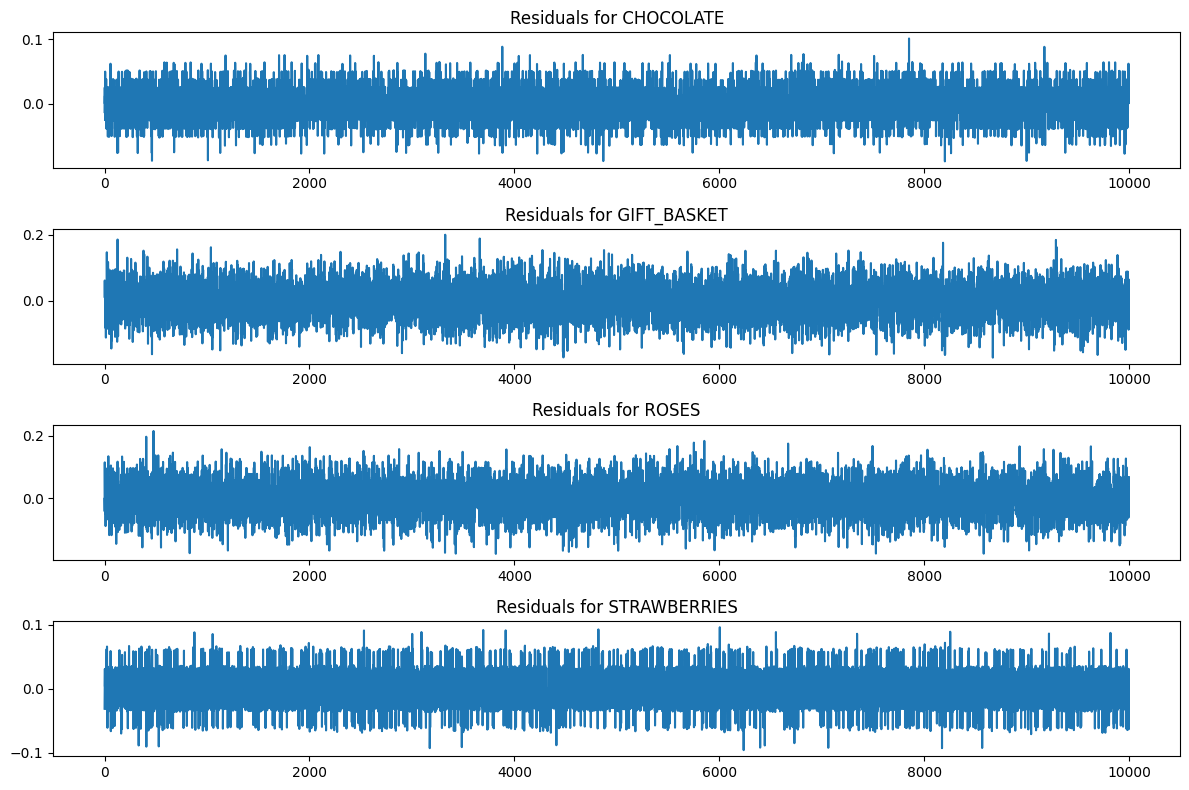

In [83]:
# Assuming vecm_result is the fitted VECM model object
residuals = vecm_result.resid

# Plot residuals to check for any obvious patterns
plt.figure(figsize=(12, 8))
for i, col in enumerate(df_day_0_scaled.columns):
    plt.subplot(len(df_day_0_scaled.columns), 1, i + 1)
    plt.plot(residuals[:, i])
    plt.title(f"Residuals for {col}")
plt.tight_layout()
plt.show()

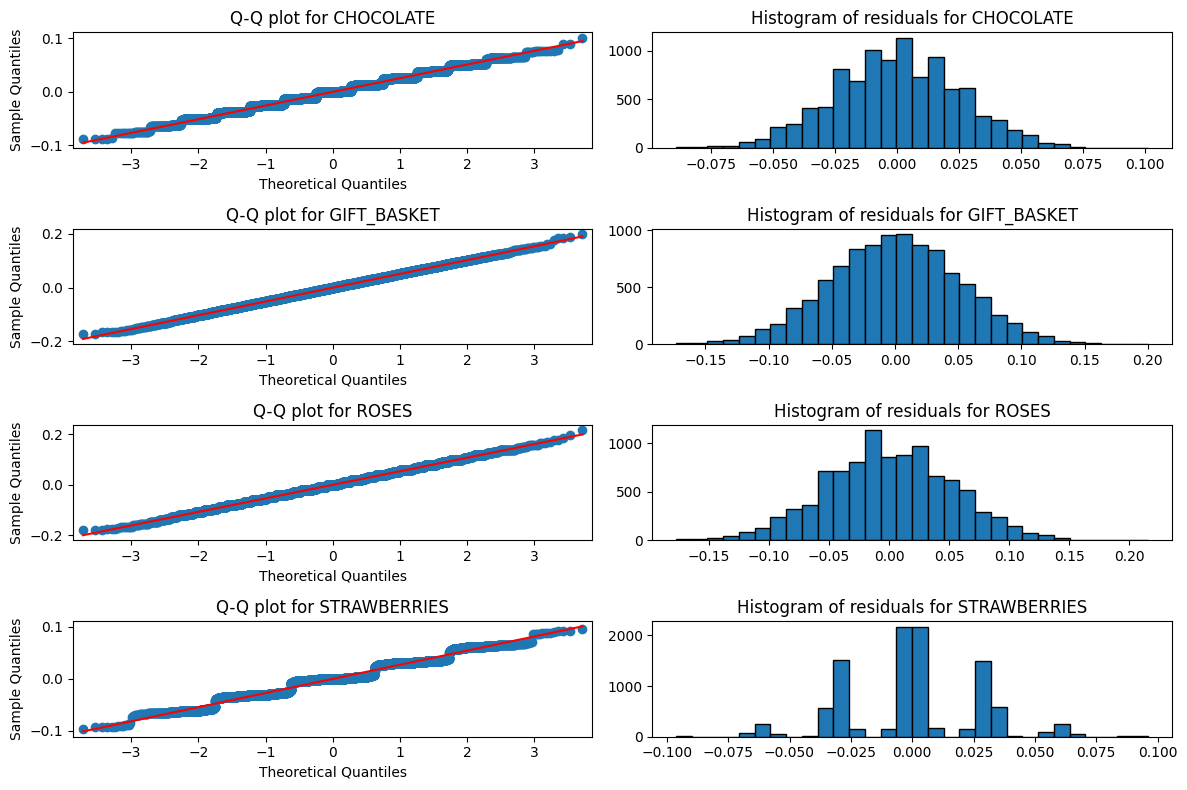

In [84]:
# Histogram and Q-Q plot for residuals of each variable
fig, axes = plt.subplots(nrows=len(df_day_0_scaled.columns), ncols=2, figsize=(12, 8))
for i, col in enumerate(df_day_0_scaled.columns):
    sm.qqplot(residuals[:, i], line="s", ax=axes[i, 0])
    axes[i, 0].set_title(f"Q-Q plot for {col}")
    axes[i, 1].hist(residuals[:, i], bins=30, edgecolor="black")
    axes[i, 1].set_title(f"Histogram of residuals for {col}")
plt.tight_layout()
plt.show()

Step 3: Stability Checks  
Check the eigenvalues of the VECM to ensure the stability of the model


In [85]:
print(vecm_result.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation CHOCOLATE
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
L1.CHOCOLATE       -0.0379      0.012     -3.178      0.001      -0.061      -0.015
L1.GIFT_BASKET      0.0158      0.007      2.426      0.015       0.003       0.029
L1.ROSES           -0.0022      0.005     -0.414      0.679      -0.012       0.008
L1.STRAWBERRIES    -0.0130      0.010     -1.321      0.186      -0.032       0.006
Det. terms outside the coint. relation & lagged endog. parameters for equation GIFT_BASKET
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
L1.CHOCOLATE        0.0399      0.024      1.668      0.095      -0.007       0.087
L1.GIFT_BASKET     -0.0387      0.013     -2.964      0.003     

In [ ]:
# Predict the next values using the coefficients from the VECM results
# Predict next values using L1 and L2 coefficients
    next_chocolate = (-0.0385 * chocolate_last + 0.0158 * gift_basket_last - 0.0022 * roses_last - 0.0130 * strawberries_last
                      + L2_CHOCOLATE * chocolate_prev + L2_GIFT_BASKET * gift_basket_prev + L2_ROSES * roses_prev + L2_STRAWBERRIES * strawberries_prev)
    next_gift_basket = (0.0399 * chocolate_last - 0.0387 * gift_basket_last + 0.0236 * roses_last + 0.0049 * strawberries_last
                        + L2_CHOCOLATE * chocolate_prev + L2_GIFT_BASKET * gift_basket_prev + L2_ROSES * roses_prev + L2_STRAWBERRIES * strawberries_prev)
    next_roses = (-0.0070 * chocolate_last + 0.0180 * gift_basket_last - 0.0202 * roses_last - 0.0408 * strawberries_last
                  + L2_CHOCOLATE * chocolate_prev + L2_GIFT_BASKET * gift_basket_prev + L2_ROSES * roses_prev + L2_STRAWBERRIES * strawberries_prev)
    next_strawberries = (0.0014 * chocolate_last + 0.0193 * gift_basket_last - 0.0123 * roses_last - 0.1256 * strawberries_last
                         + L2_CHOCOLATE * chocolate_prev + L2_GIFT_BASKET * gift_basket_prev + L2_ROSES * roses_prev + L2_STRAWBERRIES * strawberries_prev)
    


In [114]:
# # Obtain the cointegration rank test results, which includes eigenvalues
# coint_rank_test = vecm_result.test_coint_rank()

# # Eigenvalues from the VECM model's cointegration rank test
# eigenvalues = coint_rank_test.eigenvalues

# # Check if all eigenvalues lie inside the unit circle
# inside_unit_circle = np.all(np.abs(eigenvalues) < 1)

# print("Eigenvalues of the model:", eigenvalues)
# print("All eigenvalues lie inside the unit circle:", inside_unit_circle)

# # Plot eigenvalues to visualize stability
# plt.figure(figsize=(6, 6))
# plt.scatter(eigenvalues.real, eigenvalues.imag, color="red", label="Eigenvalues")
# unit_circle = plt.Circle((0, 0), 1, edgecolor="blue", facecolor="none")
# plt.gca().add_patch(unit_circle)
# plt.xlim(-1.1, 1.1)
# plt.ylim(-1.1, 1.1)
# plt.title("Eigenvalues (stability plot)")
# plt.xlabel("Real Part")
# plt.ylabel("Imaginary Part")
# plt.axhline(0, color="black", linewidth=0.5)
# plt.axvline(0, color="black", linewidth=0.5)
# plt.grid(True)
# plt.legend()
# plt.show()

AttributeError: 'VECMResults' object has no attribute 'test_coint_rank'

Explanation:  
Residual Plots: Visually inspect for any obvious patterns such as trends or seasonality.
Autocorrelation Test: Ljung-Box test results will indicate if there is significant autocorrelation at the specified lags.
Histogram and Q-Q Plots: Help to verify if residuals are normally distributed.
Stability Check: Eigenvalues should lie within the unit circle for the VECM to be considered stable. The plot will visually confirm this by showing eigenvalues in relation to the unit circle.


Step 1: Forecasting with VECM
First, we'll use the forecast() method from your fitted VECM model to predict future values.

Forecasting Example
Assuming vecm_result is your fitted VECM model and df_day_0_scaled is your DataFrame


In [62]:
df_day_0

product,CHOCOLATE,GIFT_BASKET,ROSES,STRAWBERRIES
timestamp,,,,
0,7988.0,71114.5,14545.5,4030.5
100,7988.0,71114.0,14543.5,4030.5
200,7987.5,71115.5,14543.5,4030.0
300,7988.5,71123.5,14541.5,4030.0
400,7989.5,71132.5,14547.5,4030.0
...,...,...,...,...
999500,7883.0,70589.5,14421.0,4036.5
999600,7885.5,70599.5,14418.0,4036.5
999700,7885.5,70585.5,14421.5,4035.5


In [79]:
df_day_zero = df_day_0

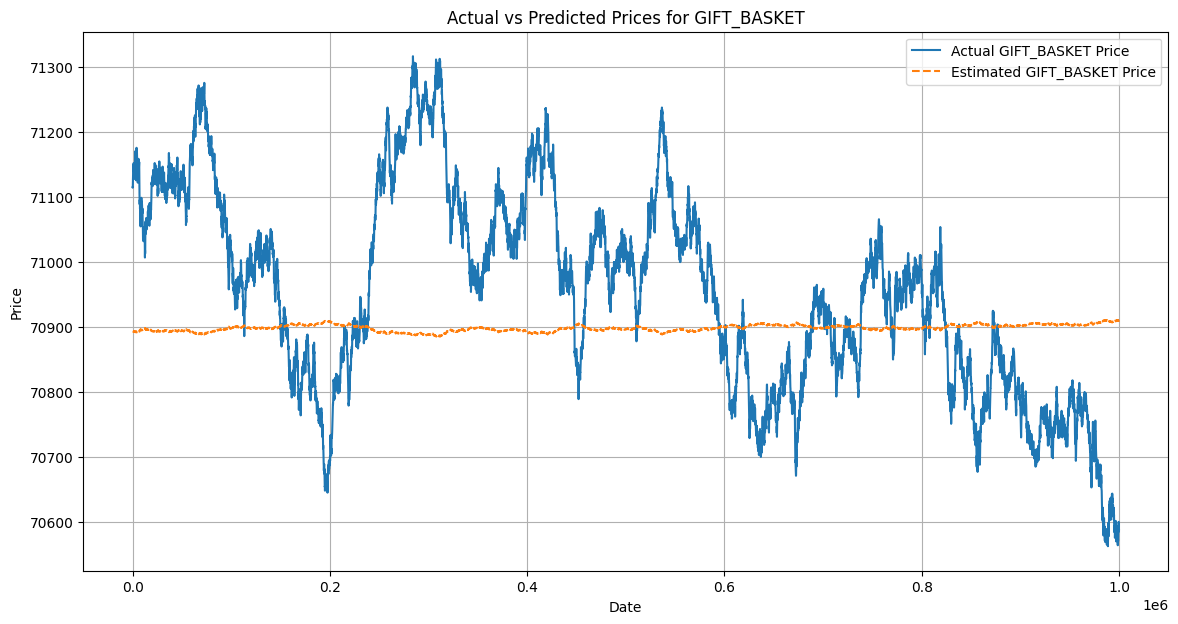

In [80]:
# Update the 'gift_basket_estimated_price' calculation using the VECM results:
df_day_zero["gift_basket_estimated_price"] = (
    73200
    + 0.0409 * df_day_zero["CHOCOLATE"].shift(1)  # L1.CHOCOLATE coefficient
    + 0.0057 * df_day_zero["CHOCOLATE"].shift(2)  # L2.CHOCOLATE coefficient
    - 0.0393 * df_day_zero["GIFT_BASKET"].shift(1)  # L1.GIFT_BASKET coefficient
    - 0.0028 * df_day_zero["GIFT_BASKET"].shift(2)  # L2.GIFT_BASKET coefficient
    + 0.0239 * df_day_zero["ROSES"].shift(1)  # L1.ROSES coefficient
    - 0.0115 * df_day_zero["ROSES"].shift(2)  # L2.ROSES coefficient
    + 0.0078 * df_day_zero["STRAWBERRIES"].shift(1)  # L1.STRAWBERRIES coefficient
    + 0.0256 * df_day_zero["STRAWBERRIES"].shift(2)  # L2.STRAWBERRIES coefficient
)

# Calculate spread based on new estimated price
df_day_zero["spread"] = (
    df_day_zero["GIFT_BASKET"] - df_day_zero["gift_basket_estimated_price"]
)


plt.figure(figsize=(14, 7))
plt.plot(
    df_day_zero.index, df_day_zero["GIFT_BASKET"], label="Actual GIFT_BASKET Price"
)
plt.plot(
    df_day_zero.index,
    df_day_zero["gift_basket_estimated_price"],
    label="Estimated GIFT_BASKET Price",
    linestyle="--",
)
plt.title("Actual vs Predicted Prices for GIFT_BASKET")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

In [75]:
df_day_0["chocolate_q"] = 4
df_day_0["roses_q"] = 1
df_day_0["strawberries_q"] = 8
df_day_0["gift_basket_stated_price"] = (
    4 * df_day_0.CHOCOLATE + 1 * df_day_0.ROSES + 8 * df_day_0.STRAWBERRIES
)
df_day_0["gift_basket_estimated_price"] = (
    -14653
    + 4.6 * df_day_0.CHOCOLATE
    + 1.2 * df_day_0.ROSES
    + 7.8 * df_day_0.STRAWBERRIES
)
df_day_0["spread"] = df_day_0.GIFT_BASKET - df_day_0.gift_basket_estimated_price
df_day_0["gift_basket_varest"] = (
    4020
    + 0.18 * df_day_0.CHOCOLATE.shift(1)
    - 0.17 * df_day_0.CHOCOLATE.shift(2)
    + 0.05 * df_day_0.ROSES.shift(1)
    - 0.05 * df_day_0.ROSES.shift(2)
    + 0.15 * df_day_0.STRAWBERRIES.shift(1)
    - 0.11 * df_day_0.STRAWBERRIES.shift(2)
    + 0.97 * df_day_0.GIFT_BASKET.shift(1)
    - 0.03 * df_day_0.GIFT_BASKET.shift(2)
)
df_day_0["chocolate_varest"] = (
    345.916942
    + 0.961326 * df_day_0.CHOCOLATE.shift(1)
    + 0.003972 * df_day_0.CHOCOLATE.shift(2)
    - 0.001652 * df_day_0.ROSES.shift(1)
    + 0.001503 * df_day_0.ROSES.shift(2)
    - 0.030947 * df_day_0.STRAWBERRIES.shift(1)
    + 0.029269 * df_day_0.STRAWBERRIES.shift(2)
    + 0.003972 * df_day_0.GIFT_BASKET.shift(1)
    - 0.003957 * df_day_0.GIFT_BASKET.shift(2)
)


df_day_0

product,CHOCOLATE,GIFT_BASKET,ROSES,STRAWBERRIES,chocolate_q,roses_q,strawberries_q,gift_basket_stated_price,gift_basket_estimated_price,spread,gift_basket_varest,chocolate_varest
timestamp,,,,,,,,,,,,
0,7988.0,71114.5,14545.5,4030.5,4,1,8,78741.5,70984.3,130.2,NaN,NaN
100,7988.0,71114.0,14543.5,4030.5,4,1,8,78739.5,70981.9,132.1,NaN,NaN
200,7987.5,71115.5,14543.5,4030.0,4,1,8,78733.5,70975.7,139.8,71108.145,8048.854943
300,7988.5,71123.5,14541.5,4030.0,4,1,8,78735.5,70977.9,145.6,71109.550,8048.394684
400,7989.5,71132.5,14547.5,4030.0,4,1,8,78745.5,70989.7,142.8,71117.485,8049.368534
...,...,...,...,...,...,...,...,...,...,...,...,...
999500,7883.0,70589.5,14421.0,4036.5,4,1,8,78245.0,70398.7,190.8,70614.595,7947.507772
999600,7885.5,70599.5,14418.0,4036.5,4,1,8,78252.0,70406.6,192.9,70614.260,7947.528715
999700,7885.5,70585.5,14421.5,4035.5,4,1,8,78247.5,70403.0,182.5,70624.420,7949.945934


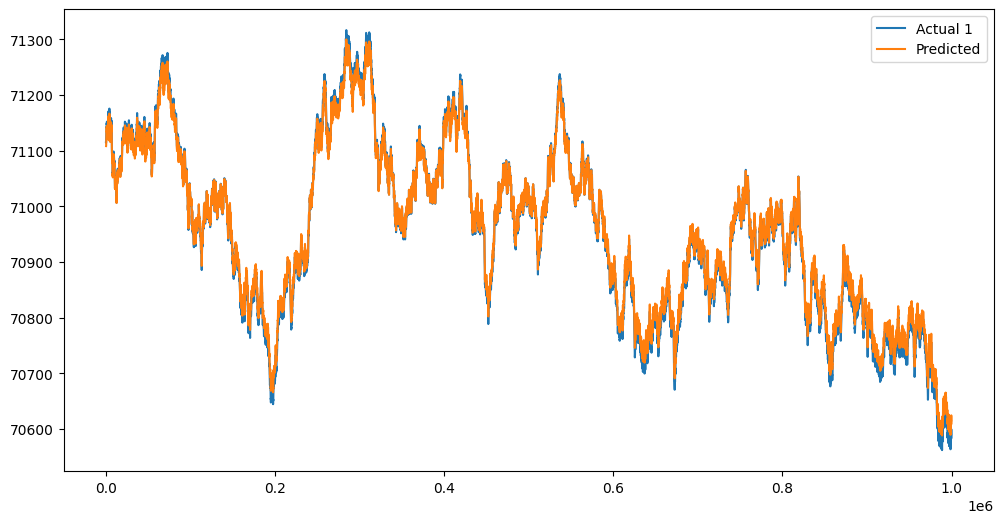

In [60]:
plt.figure(figsize=(12, 6))
plt.plot(df_day_0["GIFT_BASKET"].shift(1), label="Actual 1")
plt.plot(df_day_0["gift_basket_varest"], label="Predicted")
plt.legend()
plt.show()

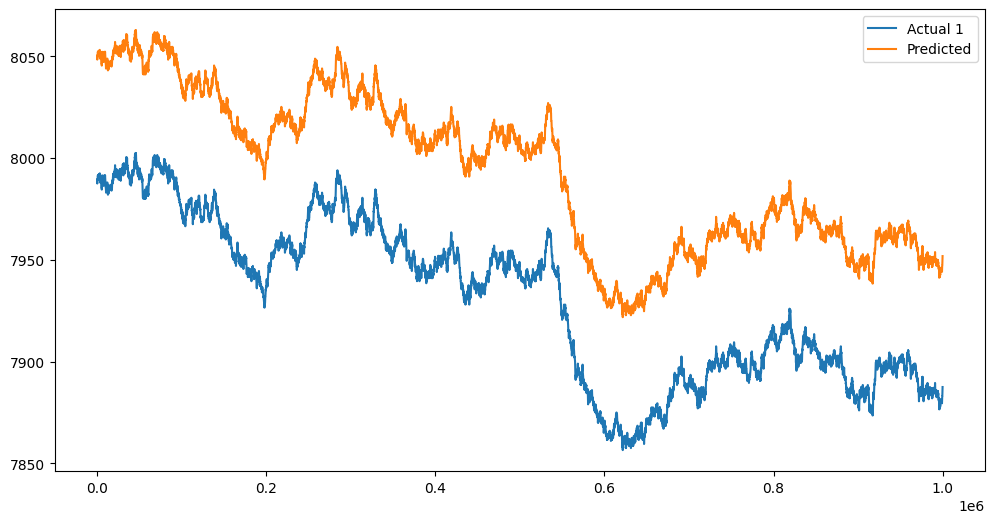

In [76]:
plt.figure(figsize=(12, 6))
plt.plot(df_day_0["CHOCOLATE"].shift(1), label="Actual 1")
plt.plot(df_day_0["chocolate_varest"], label="Predicted")
plt.legend()
plt.show()

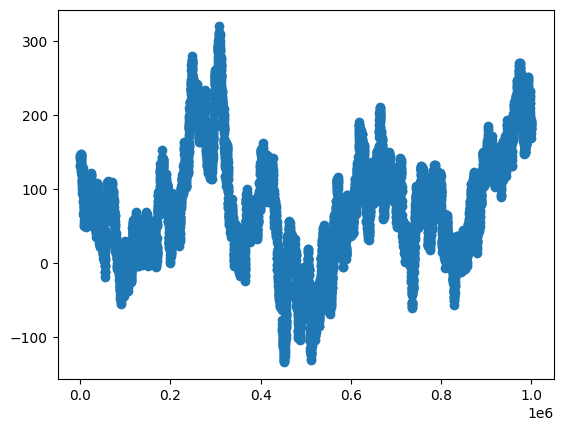

In [77]:
plt.plot(df_day_0.spread, label="Actual 1", marker="o")

plt.show()

In [149]:
df_day_0["spread"].mean()

45.71749000000494

In [152]:
df_day_0["spread"].std()
df_day_0["gift_basket_stated_price"].corr(df_day_0["GIFT_BASKET"])

0.8530106570445289